In [1]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns

sns.set()

from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
# Buils ROC_AUC Curve
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.rcParams['figure.figsize'] = (12, 4)
    plt.show()

In [3]:
# Plots confusion matrix and metrics
def confusion_metric(test_Y, preds):
    
    # save confusion matrix and slice
    confusion = metrics.confusion_matrix(test_Y, preds)
    print(confusion)
    
    #[row, column]
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    
    #Performance
    print("Classification Error: %.2f%%" % ((FP + FN) / float(TP + TN + FP + FN)))
    print("Sensitivity: %.2f%%" % (TP / float(FN + TP)))
    print("Specificity: %.2f%%" % (TN / (TN + FP)))
    print("False Positive Rate: %.2f%%" % (FP / float(TN + FP)))
    print("Precision: %.2f%%" % (TP / float(TP + FP)))

In [4]:
# Fits XGBoost model and displays performance metrics
def modelfit(alg, train_X, train_Y,
             useTrainCV=True, cv_folds=5, early_stopping_rounds=50, 
             testModel=False, test_X=None, test_Y=None, 
             plotTree=False, confusionMetric=False, returnAlg=False):
    
    # Train model
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgb_train = xgb.DMatrix(train_X, label=train_Y)
        cvresult = xgb.cv(xgb_param, xgb_train, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    # Fit the algorithm on the data
    alg.fit(train_X, train_Y,eval_metric='auc')
        
    # Predict training set:
    preds_train = alg.predict(train_X)
    preds_prob_train = alg.predict_proba(train_X)[:,1]
        
    # Print model training report:
    print("\nModel (Train) Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(train_Y, preds_train))
    print("AUC Score : %f" % metrics.roc_auc_score(train_Y, preds_prob_train))
    buildROC(train_Y, preds_prob_train)
               
    # Optional: Model Testing
    if testModel:
        # Predict testing set:
        preds_test = alg.predict(test_X)
        preds_prob_test = alg.predict_proba(test_X)[:,1]
        
        # Print model testing report
        print("\nModel (Test) Report")
        print("Accuracy : %.4g" % metrics.accuracy_score(test_Y, preds_test))
        print("AUC Score : %f" % metrics.roc_auc_score(test_Y, preds_prob_test))
        buildROC(test_Y, preds_prob_test)
        
        # Plot Confusion Metrics
        if confusionMetric:
            print("\nConfusion Matrix Report")
            confusion_metric(test_Y, preds_test)
    
    # Plot feature importance:
    print("\nFeature Importance Report")
    xgb.plot_importance(alg, show_values=False, max_num_features=10)
    plt.rcParams['figure.figsize'] = (12, 6)
    plt.show()
    
    # Plot tree
    if plotTree:
        print("\nTree Viz")
        xgb.plot_tree(alg)
        plt.rcParams['figure.figsize'] = (12, 6)
        plt.show()
    
    if returnAlg:
        return alg

In [41]:
# Load, format, and split clustered daily data
X = pd.read_csv("FullClust2018.csv")
X.drop(['Unnamed: 0', 'Cluster'], axis=1, inplace=True)
Y = np.where(X['NAS'] == 0, -1, 1)
    
train_set_size = 0.8

train_X, test_X, __, test_Y = train_test_split(X, Y, test_size=.2, random_state=42)

train_X = train_X.sort_values(by=['NAS'])
train_X = train_X[225000:]
train_Y = np.where(train_X['NAS'] == 0, -1, 1)
train_X.drop('NAS', axis=1, inplace=True)
test_X.drop('NAS', axis=1, inplace=True)
train_Y.shape[0]  / (test_Y.shape[0] + train_Y.shape[0])
train_Y[train_Y != -1].shape[0], train_Y[train_Y != 1].shape[0]

train_Y[train_Y == -1] = 0
test_Y[test_Y == -1] = 0

/Users/kais/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,



Model (Train) Report
Accuracy : 0.6027
AUC Score : 0.669507


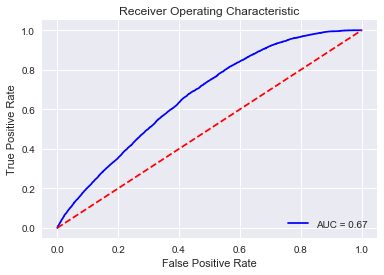


Model (Test) Report
Accuracy : 0.7351
AUC Score : 0.650727


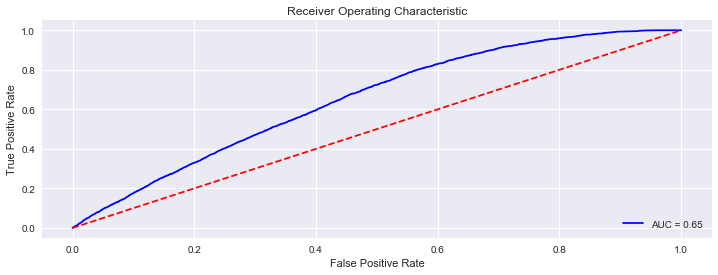


Confusion Matrix Report
[[46872 14746]
 [ 2784  1769]]
Classification Error: 0.26%
Sensitivity: 0.39%
Specificity: 0.76%
False Positive Rate: 0.24%
Precision: 0.11%

Feature Importance Report


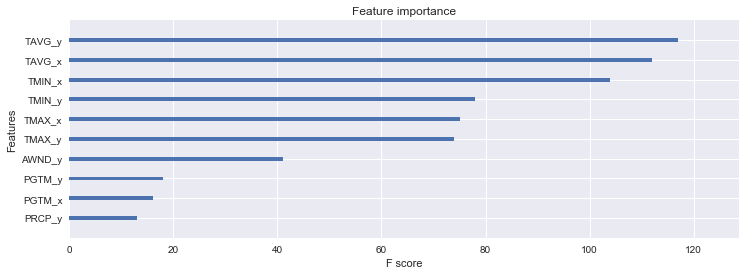


Tree Viz


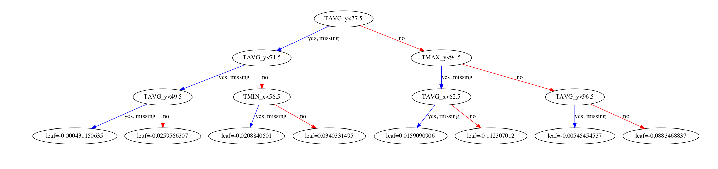

In [43]:
#Untuned xgboost model results
xgb1 = xgb.XGBClassifier(objective ='binary:logistic')
modelfit(xgb1, train_X, train_Y, 
         testModel=True, test_X=test_X, test_Y=test_Y,
         plotTree=True, confusionMetric=True)

In [ ]:
# Tune values for max_depth and min_child_weight in range to find optimal values
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_X,train_Y)
gsearch1.best_params_, gsearch1.best_score_

In [ ]:
# Tune values for max_depth and min_child_weight around optimals found in gsearch1
param_test2 = {
 'max_depth':[8,9,10],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train_X,train_Y)
gsearch2.best_params_, gsearch1.best_score_

In [ ]:
# Tune values for gamme in range to find optimal values
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train_X,train_Y)
gsearch3.best_params_, gsearch3.best_score_

In [ ]:
# Tune values for gamma around optimal found in gsearch3
param_test4 = {
 'gamma':[0.35,0.4,0.45]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=9,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train_X,train_Y)
gsearch4.best_params_, gsearch4.best_score_


Model (Train) Report
Accuracy : 0.7464
AUC Score : 0.833086


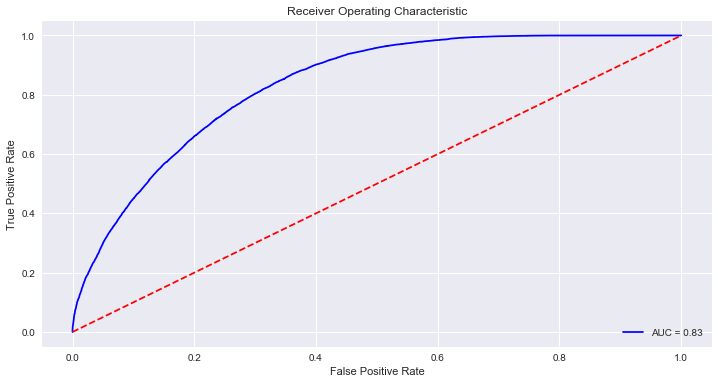


Model (Test) Report
Accuracy : 0.6481
AUC Score : 0.716012


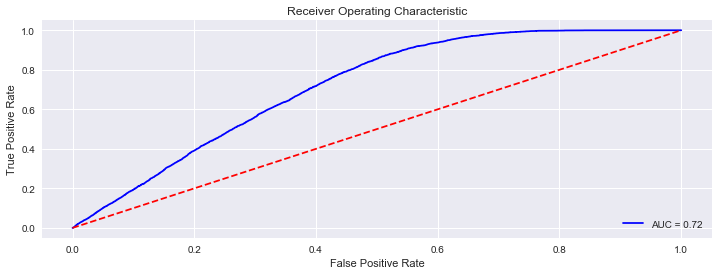


Confusion Matrix Report
[[39971 21647]
 [ 1638  2915]]
Classification Error: 0.35%
Sensitivity: 0.64%
Specificity: 0.65%
False Positive Rate: 0.35%
Precision: 0.12%

Feature Importance Report


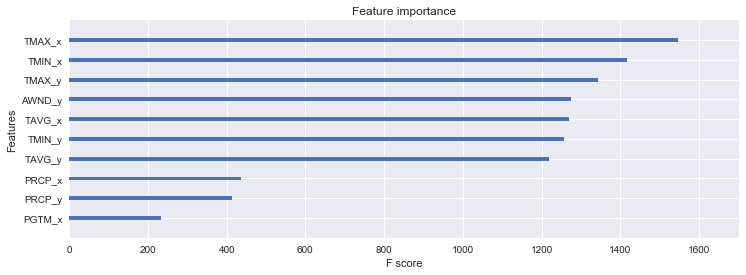


Tree Viz


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.914564 to fit


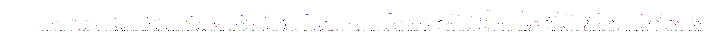

In [44]:
#max_depth, min_child_weight, and gamma tuned xgboost model results
xgb2 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=9,
 min_child_weight=5,
 gamma=0.4,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train_X, train_Y, 
         testModel=True, test_X=test_X, test_Y=test_Y,
         plotTree=True, confusionMetric=True)

In [ ]:
# Tune values for subsample and colsample_bytree in range to find optimal values
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=5, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train_X, train_Y)
gsearch4.best_params_, gsearch4.best_score_

In [ ]:
# Tune values for subsample and colsample_bytree around optimal found in gsearch4
param_test5 = {
 'subsample':[i/100.0 for i in range(55,70,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=5, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train_X, train_Y)
gsearch5.best_params_, gsearch4.best_score_


Model (Train) Report
Accuracy : 0.7398
AUC Score : 0.826081


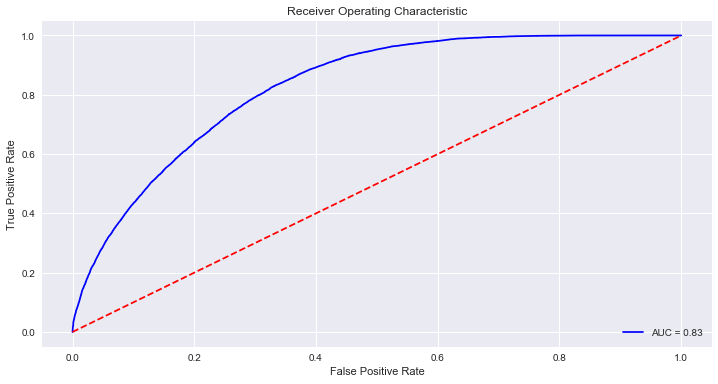


Model (Test) Report
Accuracy : 0.6503
AUC Score : 0.713575


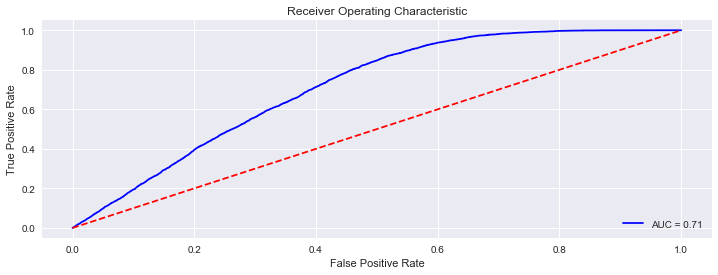


Confusion Matrix Report
[[40152 21466]
 [ 1675  2878]]
Classification Error: 0.35%
Sensitivity: 0.63%
Specificity: 0.65%
False Positive Rate: 0.35%
Precision: 0.12%

Feature Importance Report


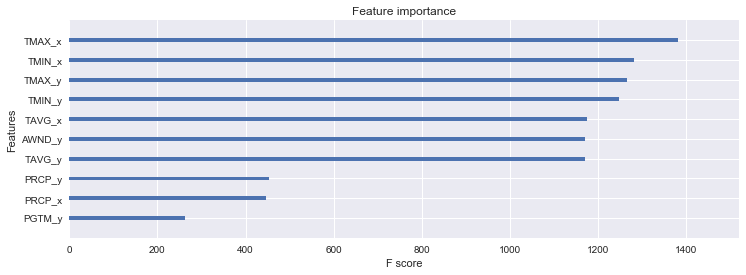


Tree Viz


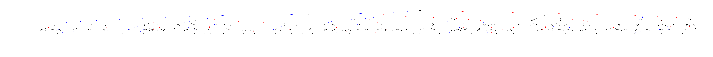

In [46]:
#max_depth, min_child_weight, gamma, colsample_bytree, ratio, and subsample tuned xgboost model results
xgb3 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=9,
 min_child_weight=5,
 gamma=0.4,
 subsample=0.65,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train_X, train_Y, 
         testModel=True, test_X=test_X, test_Y=test_Y,
         plotTree=True, confusionMetric=True)